# Stock Return Prediction

As part of our student project, we are participating in the Qube Research & Technologies (QRT) financial prediction challenge, which focuses on forecasting the sign of residual stock returns—returns adjusted to remove overall market impact—using recent historical data.

The dataset includes over 600,000 observations, split into 418,595 training samples and 198,429 test samples. Each sample contains 20 days of historical residual returns and relative volumes, along with categorical features such as STOCK, SECTOR, INDUSTRY, and SUB_INDUSTRY. The objective is to predict whether the return on a given day is positive or negative, using only this historical and contextual information.

The evaluation metric is accuracy, based on correctly classifying the return sign. 

Through this project, our team aims to explore advanced modeling approaches, including gradient boosting, deep learning, and random forest, to better extract predictive signals from noisy financial data. This challenge provides a hands-on opportunity to apply data science techniques in a high-dimensional, real-world market context.

## Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import time


## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
# The files are assumed to be in the specified paths
x_train = pd.read_csv('~/Desktop/QRT/x_train.csv', index_col='ID')
y_train = pd.read_csv('~/Desktop/QRT/y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('~/Desktop/QRT/x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


## Data Cleaning

Before training any predictive models, we ensure the dataset is clean, consistent, and properly formatted. In this step, we focused on identifying and handling missing values, verifying data types, and checking for anomalies or outliers in the input features. 

Since the dataset includes 40 numerical time-series features (returns and volumes) and several categorical identifiers (such as STOCK, SECTOR, and INDUSTRY), we also ensured that all features were encoded appropriately for modeling. Missing values in the time-series data were handled, while categorical variables were processed to maintain consistency across training and test sets. 

In [3]:
# Check data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

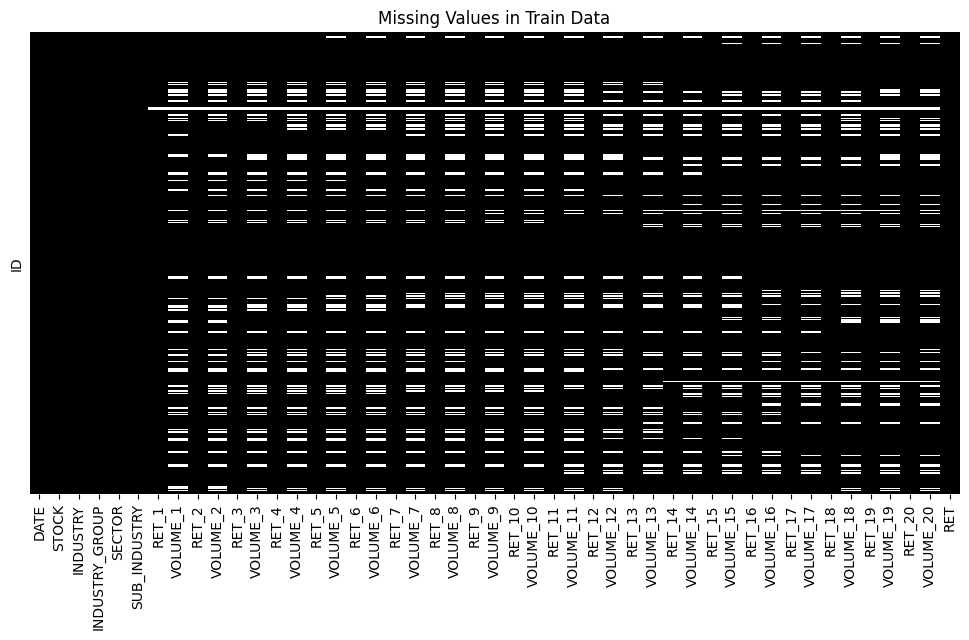

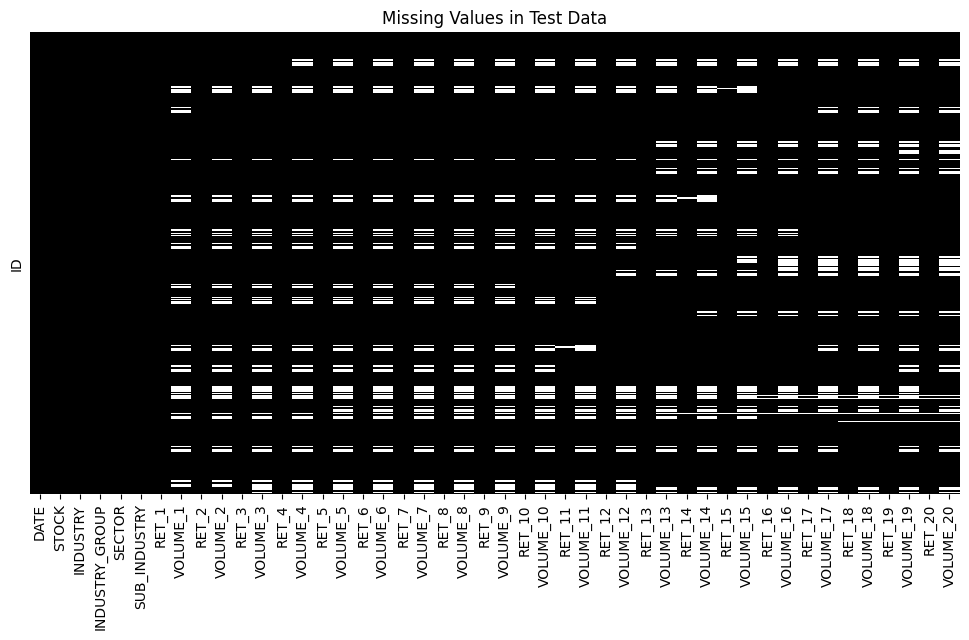

In [4]:
# Visualize missing values in the train and test datasets
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Train Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Test Data')
plt.show()

In [5]:
# Handle missing values:
# - Drop rows with any missing RET_1 to RET_20 in both train and test
# - Fill missing VOLUME with mean by INDUSTRY_GROUP and DATE

ret_cols = [f'RET_{i+1}' for i in range(20)]
vol_cols = [f'VOLUME_{i+1}' for i in range(20)]

def drop_missing_ret(df, name=""):
    original_rows = len(df)
    df_clean = df.dropna(subset=ret_cols)
    rows_dropped = original_rows - len(df_clean)
    percent_dropped = 100 * rows_dropped / original_rows
    print(f"{name} Rows dropped due to RET missing: {rows_dropped} ({percent_dropped:.2f}%)")
    return df_clean

train = drop_missing_ret(train, "Train")
test = drop_missing_ret(test, "Test")

# Fill missing VOLUME with mean by INDUSTRY_GROUP and DATE
for col in vol_cols:
    train[col] = train.groupby(['INDUSTRY_GROUP', 'DATE'])[col].transform(lambda x: x.fillna(x.mean()))
    test[col] = test.groupby(['INDUSTRY_GROUP', 'DATE'])[col].transform(lambda x: x.fillna(x.mean()))

Train Rows dropped due to RET missing: 6126 (1.46%)
Test Rows dropped due to RET missing: 4494 (2.26%)


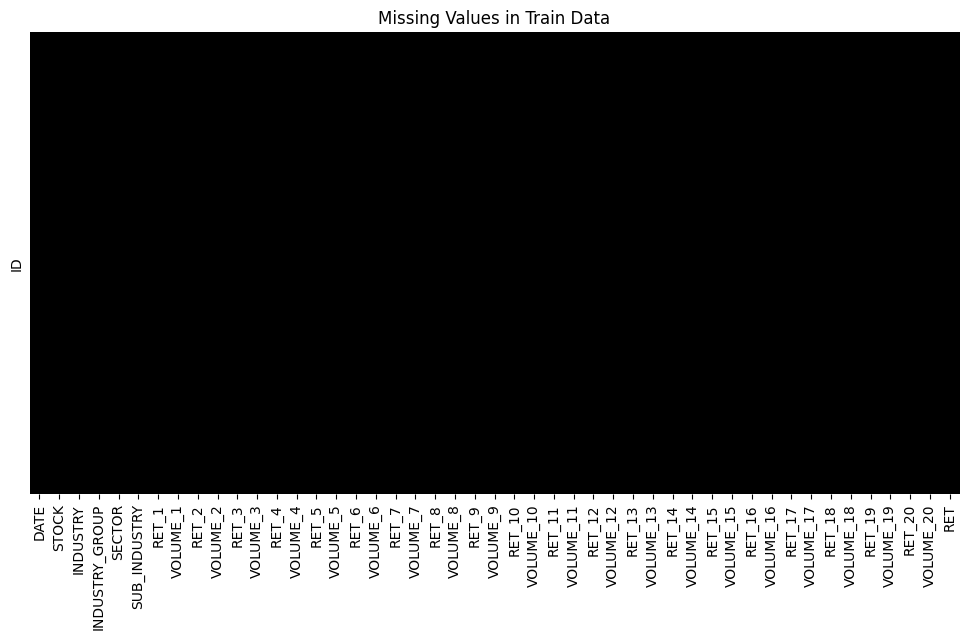

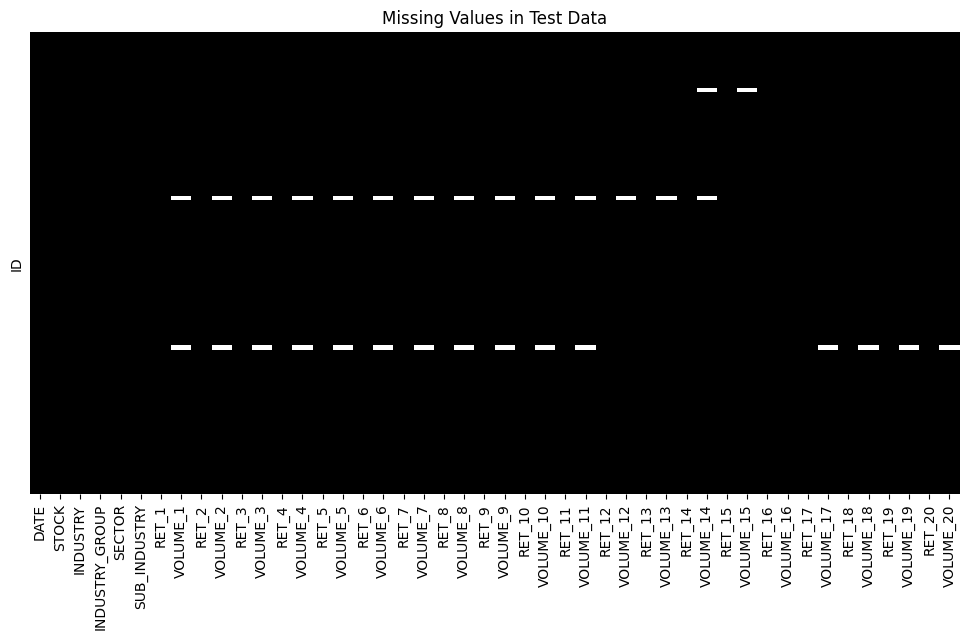

In [7]:
# Check for missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Train Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Test Data')
plt.show()

## Feature Engineering

To improve model performance, we engineered a range of time-series and cross-sectional features derived from the 20-day history of residual stock returns (`RET_1` to `RET_20`). These features are designed to capture trends, momentum, relative performance, and volatility—key factors often used in quantitative finance models.

### Moving Averages (MA)

We computed simple moving averages (SMA) over 5-day and 10-day windows to smooth recent return fluctuations and extract trend information. For each window size \( N \), we calculated rolling means of returns shifted over different lags, such as the average return from days 1–5, 2–6, etc., up to `RET_16` when \( N = 5 \). This resulted in multiple lagged MA features (`RET_MA5_k`, `RET_MA10_k`) that allow the model to detect changes in trend patterns over time.

### Exponential Moving Averages (EMA)

To give more weight to recent returns, we also introduced exponential moving averages with decay factors based on 5 and 10-day windows. The EMA calculation started from the most recent day (`RET_20`) and recursively propagated backward using a smoothing factor \(\alpha = 2 / (N + 1)\). This approach generates time-sensitive features (`RET_EMA5_k`, `RET_EMA10_k`) that adapt more quickly to recent movements compared to simple averages.

### MACD (Moving Average Convergence Divergence)

Using the difference between short-term and long-term EMAs (5-day and 10-day), we computed MACD-style features (`RET_MACD_k`) for each of the last 19 return days. These features are commonly used in momentum-based trading strategies to identify when a stock is gaining or losing momentum. A positive MACD suggests upward momentum, while a negative value may signal a potential downward trend.

### Sector and Industry Group Relative Returns

To incorporate market structure, we calculated the average return per sector and industry group for each return lag (`RET_IN_SECTOR_k`, `RET_IN_GROUP_k`). These cross-sectional features measure how a stock performs relative to its peers on a given day, which is especially valuable for capturing sector-wide movements or anomalies. Grouping was done using the `DATE` and either `SECTOR` or `INDUSTRY_GROUP` fields.

### Volatility

Finally, we added a global volatility feature by computing the standard deviation of the full 20-day return window (`RET_1` to `RET_20`) for each stock. This provides a measure of how stable or volatile the recent performance has been, which may influence the likelihood of a directional movement.

All of these features were computed and concatenated efficiently using pandas, ensuring they are aligned with the original dataset. The enriched feature set allows the model to exploit both temporal and structural patterns in the data, potentially improving its ability to predict the residual return sign accurately.

In [8]:
def add_technical_features(df):
    N_MA = [5, 10]
    N_EMA = [5, 10]
    n_ret = 20
    features = {}

    # Moving averages
    for N in N_MA:
        for shift in range(n_ret - N):
            cols = [f'RET_{n+shift+1}' for n in range(N)]
            if all(col in df.columns for col in cols):
                features[f'RET_MA{N}_{shift+1}'] = df[cols].mean(axis=1)

    # Sector and industry group means
    for n in range(n_ret):
        col = f'RET_{n+1}'
        if col in df.columns:
            features[f'RET_IN_SECTOR_{n+1}'] = df.groupby(['DATE', 'SECTOR'])[col].transform('mean')
            features[f'RET_IN_GROUP_{n+1}'] = df.groupby(['DATE', 'INDUSTRY_GROUP'])[col].transform('mean')

    # Exponential moving averages
    for n_ema in N_EMA:
        alpha = 2 / (n_ema + 1)
        if f'RET_19' in df.columns and f'RET_20' in df.columns:
            features[f'RET_EMA{n_ema}_19'] = df['RET_19'] * alpha + df['RET_20'] * (1 - alpha)
            for n in range(18, 0, -1):
                col = f'RET_{n}'
                next_ema = f'RET_EMA{n_ema}_{n+1}'
                if col in df.columns and next_ema in features:
                    features[f'RET_EMA{n_ema}_{n}'] = df[col] * alpha + features[next_ema] * (1 - alpha)

    # MACD
    for n in range(19):
        ema_long = f'RET_EMA{N_EMA[1]}_{n+1}'
        ema_short = f'RET_EMA{N_EMA[0]}_{n+1}'
        if ema_long in features and ema_short in features:
            features[f'RET_MACD_{n+1}'] = features[ema_long] - features[ema_short]

    # Volatility
    ret_cols = [f'RET_{i+1}' for i in range(n_ret) if f'RET_{i+1}' in df.columns]
    if ret_cols:
        features['VOLATILITY'] = df[ret_cols].std(axis=1)

    # Concatenate all new features at once
    return pd.concat([df, pd.DataFrame(features, index=df.index)], axis=1)

# Apply to both train and test
train = add_technical_features(train)
test = add_technical_features(test)

## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [34]:
# Feature selection based on historical values and engineered features
try:
    new_features
except NameError:
    new_features = []
    
N_HIST = 5
N_MA = [5, 10]
N_EMA = [5, 10]

features = []
features.append('VOLATILITY')
for n in range(N_HIST):
    features.append(f'RET_{n+1}')
    features.append(f'VOLUME_{n+1}')
    features.append(f'RET_IN_SECTOR_{n+1}')
    for n_ma in N_MA:
        if 20 - n_ma > n:
            features.append(f'RET_MA{n_ma}_{n+1}')
    for n_ema in N_EMA:
        if n + 1 < 20:
            features.append(f'RET_EMA{n_ema}_{n+1}')
    if n + 1 < 20:
        features.append(f'RET_MACD_{n+1}')

# Optionally, add any additional features (e.g., from new_features list)
features += [f for f in new_features if f not in features]

# Keep only features that exist in the dataframe
features = [f for f in features if f in train.columns]

print(f'No. of features: {len(features)}\n\nList of features:\n{features}')

# Preview the selected features
train[features].head()

No. of features: 41

List of features:
['VOLATILITY', 'RET_1', 'VOLUME_1', 'RET_IN_SECTOR_1', 'RET_MA5_1', 'RET_MA10_1', 'RET_EMA5_1', 'RET_EMA10_1', 'RET_MACD_1', 'RET_2', 'VOLUME_2', 'RET_IN_SECTOR_2', 'RET_MA5_2', 'RET_MA10_2', 'RET_EMA5_2', 'RET_EMA10_2', 'RET_MACD_2', 'RET_3', 'VOLUME_3', 'RET_IN_SECTOR_3', 'RET_MA5_3', 'RET_MA10_3', 'RET_EMA5_3', 'RET_EMA10_3', 'RET_MACD_3', 'RET_4', 'VOLUME_4', 'RET_IN_SECTOR_4', 'RET_MA5_4', 'RET_MA10_4', 'RET_EMA5_4', 'RET_EMA10_4', 'RET_MACD_4', 'RET_5', 'VOLUME_5', 'RET_IN_SECTOR_5', 'RET_MA5_5', 'RET_MA10_5', 'RET_EMA5_5', 'RET_EMA10_5', 'RET_MACD_5']


,VOLATILITY,RET_1,VOLUME_1,RET_IN_SECTOR_1,RET_MA5_1,RET_MA10_1,RET_EMA5_1,RET_EMA10_1,RET_MACD_1,RET_2,...,RET_EMA10_4,RET_MACD_4,RET_5,VOLUME_5,RET_IN_SECTOR_5,RET_MA5_5,RET_MA10_5,RET_EMA5_5,RET_EMA10_5,RET_MACD_5
ID,,,,,,,,,,,,,,,,,,,,,
0,0.054646,-0.015748,0.147931,0.009178,-0.003694,0.027665,-0.004148,0.006495,0.010643,-0.015504,...,0.018859,0.008999,0.016483,-0.972920,0.005187,0.025863,0.033353,0.022126,0.026310,0.004184
1,0.048808,0.003984,0.042790,0.006477,-0.026274,0.006335,-0.019512,-0.012469,0.007043,-0.090580,...,-0.003670,0.008142,-0.038062,-0.236635,0.005630,0.022202,0.004877,-0.004948,0.001190,0.006138
2,0.023417,0.000440,-0.096282,0.013442,-0.006658,0.001767,-0.010347,-0.004987,0.005359,-0.058896,...,0.008754,-0.004524,0.009354,0.091455,0.023137,0.000902,0.006351,0.007490,0.005176,-0.002314
3,0.020831,0.031298,-0.429540,0.017253,0.003658,-0.003982,0.008338,0.001227,-0.007111,0.007756,...,-0.009226,0.001343,0.003544,-0.882464,-0.009513,-0.006524,-0.004920,-0.006016,-0.006904,-0.000888
4,0.032045,0.027273,-0.847155,0.006241,0.002059,-0.000206,0.001495,-0.001021,-0.002517,-0.039302,...,-0.000244,-0.004085,0.022321,-1.204398,0.001533,-0.002411,0.005111,0.005763,-0.000298,-0.006060


In [35]:
# Data normalization and standardization

from sklearn.preprocessing import StandardScaler

# y is the target column from the DataFrame
y = train['RET'].values

# Fit scaler on features
scaler = StandardScaler()
scaler.fit(train[features])

# Store scaled features in new variables
X_train = scaler.transform(train[features])
X_test = scaler.transform(test[features])
y_train = train['RET'].values

## Model and local score

A Random Forest (RF) model is chosen for the Benchmark. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [36]:
target = 'RET'

In [38]:
# Model tuning with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV, GroupKFold

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [400, 500],
    'max_depth': [8, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', None]
}

# Convert X_train to DataFrame for compatibility
X_sample = pd.DataFrame(X_train, index=train.index).fillna(0)
y_sample = y_train

# Use the DATE column as groups for GroupKFold
groups = train.loc[X_sample.index, 'DATE']
group_kfold = GroupKFold(n_splits=4)

# Initialize the Random Forest
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

print("Starting RandomizedSearchCV...")

# Randomized search over parameters with progress output and GroupKFold
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=group_kfold.split(X_sample, y_sample, groups=groups),
    scoring='accuracy',
    random_state=0,
    n_jobs=-1,
    verbose=2  # Show progress
)

random_search.fit(X_sample, y_sample)

print("RandomizedSearchCV complete.")
print("Best parameters found:", random_search.best_params_)

# Use the best parameters for cross-validation
rf_params = random_search.best_params_
rf_params['random_state'] = 0
rf_params['n_jobs'] = -1

Starting RandomizedSearchCV...
Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=400; total time=10.9min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=400; total time=11.0min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=400; total time=11.0min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=400; total time=11.1min
[CV] END max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=11.1min
[CV] END max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=11.2min
[CV] END max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=11.2min
[CV] END max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=11.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500; total time=13.2min
[CV] END max_

In [39]:
# Use the best parameters for cross-validation
rf_params = random_search.best_params_
rf_params['random_state'] = 0
rf_params['n_jobs'] = -1

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

   # Use boolean indexing on the original DataFrame to get row indices
    train_idx = np.where(local_train_ids)[0]
    test_idx = np.where(local_test_ids)[0]

    X_local_train = X_train[train_idx]
    y_local_train = y_train[train_idx]
    X_local_test = X_train[test_idx]
    y_local_test = y_train[test_idx]

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.52%
Fold 2 - Accuracy: 51.11%
Fold 3 - Accuracy: 53.17%
Fold 4 - Accuracy: 52.19%
Accuracy: 52.00% [51.22 ; 52.78] (+- 0.78)


In [28]:
from sklearn.metrics import accuracy_score, classification_report

rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    # Use boolean indexing on the original DataFrame to get row indices
    train_idx = np.where(local_train_ids)[0]
    test_idx = np.where(local_test_ids)[0]

    X_local_train = X_train[train_idx]
    y_local_train = y_train[train_idx]
    X_local_test = X_train[test_idx]
    y_local_test = y_train[test_idx]

    # No fillna needed for NumPy arrays from StandardScaler

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]

    sub = train.iloc[test_idx].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score*100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


Fold 1 - Accuracy: 51.59%
Fold 2 - Accuracy: 51.17%
Fold 3 - Accuracy: 53.10%
Fold 4 - Accuracy: 52.18%
Accuracy: 52.01% [51.28 ; 52.73] (+- 0.72)


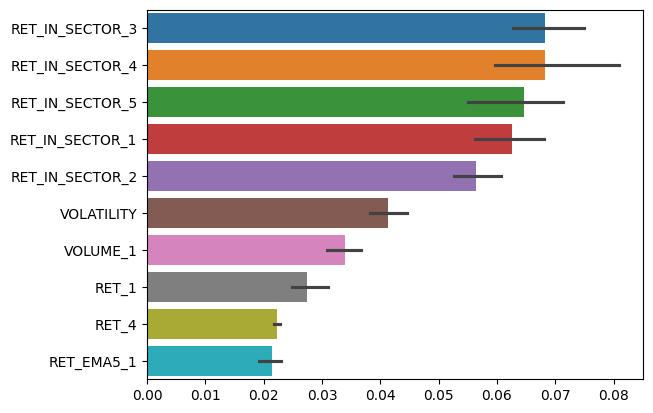

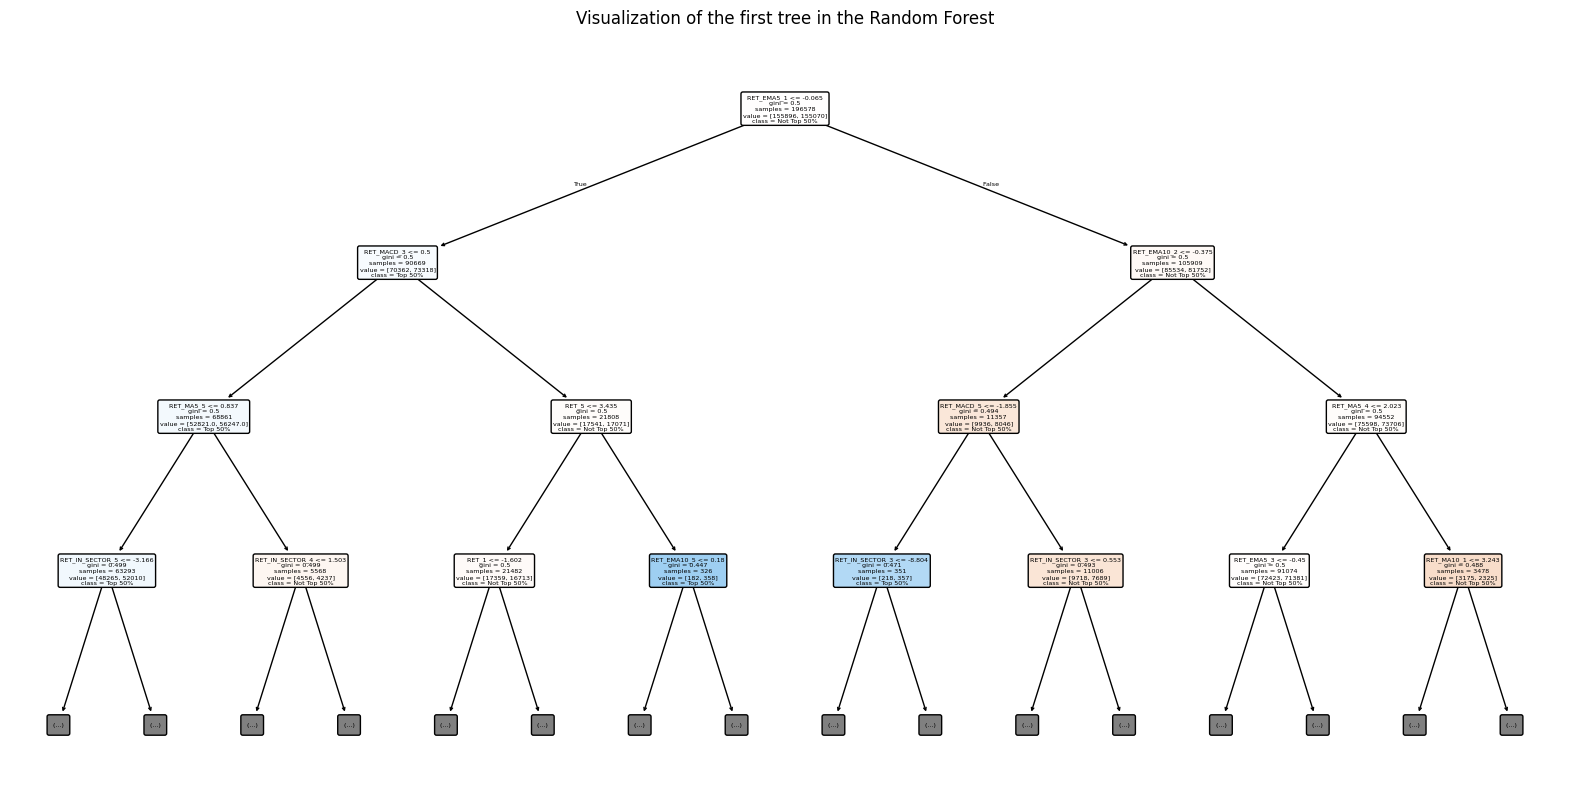

In [40]:
# Feature importances
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# Get the top 10 features by mean importance
top_features = feature_importances.mean().sort_values(ascending=False).head(10).index   

sns.barplot(
    data=feature_importances[top_features],
    orient='h',
    order=top_features
)

# Visualize the first tree from the first trained Random Forest model
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick the first model from cross-validation
rf_model = models[0]

plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0],
    feature_names=features,
    class_names=['Not Top 50%', 'Top 50%'],
    filled=True,
    rounded=True,
    max_depth=3  # Limit depth for readability
)
plt.title("Visualization of the first tree in the Random Forest")
plt.show()

Epoch 1/20


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5848/5848 - 3s - 523us/step - accuracy: 0.5040 - loss: 0.7167 - val_accuracy: 0.5037 - val_loss: 0.6985
Epoch 2/20
5848/5848 - 2s - 392us/step - accuracy: 0.5132 - loss: 0.6960 - val_accuracy: 0.5085 - val_loss: 0.6948
Epoch 3/20
5848/5848 - 2s - 384us/step - accuracy: 0.5153 - loss: 0.6939 - val_accuracy: 0.5044 - val_loss: 0.6944
Epoch 4/20
5848/5848 - 2s - 400us/step - accuracy: 0.5141 - loss: 0.6934 - val_accuracy: 0.5057 - val_loss: 0.6938
Epoch 5/20
5848/5848 - 2s - 393us/step - accuracy: 0.5155 - loss: 0.6932 - val_accuracy: 0.5068 - val_loss: 0.6938
Epoch 6/20
5848/5848 - 2s - 391us/step - accuracy: 0.5154 - loss: 0.6930 - val_accuracy: 0.5062 - val_loss: 0.6938
Epoch 7/20
5848/5848 - 2s - 390us/step - accuracy: 0.5163 - loss: 0.6930 - val_accuracy: 0.5077 - val_loss: 0.6937
Epoch 8/20
5848/5848 - 2s - 398us/step - accuracy: 0.5167 - loss: 0.6930 - val_accuracy: 0.5097 - val_loss: 0.6935
Epoch 9/20
5848/5848 - 2s - 394us/step - accuracy: 0.5151 - loss: 0.6930 - val_accuracy: 0.

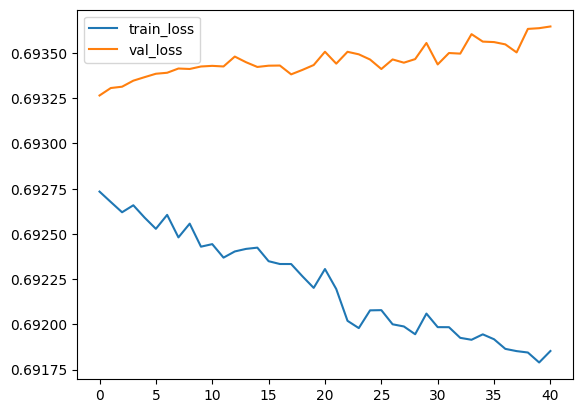

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Neural network construction
input_dim = X_train.shape[1]

# Convert y_train to integer type for binary classification
y_train = y_train.astype(int)

# --- Representative validation split based on DATE ---
unique_dates = np.sort(train['DATE'].unique())
n_val_dates = int(0.1 * len(unique_dates))
val_dates = unique_dates[-n_val_dates:]

val_mask = train['DATE'].isin(val_dates)
train_mask = ~val_mask

X_nn_train = X_train[train_mask]
y_nn_train = y_train[train_mask]
X_nn_val = X_train[val_mask]
y_nn_val = y_train[val_mask]

# Define the neural network model
nn_model = Sequential([
    Dense(150, activation='tanh', kernel_regularizer=l2(1e-4), input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(35, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


# Choices for loss, metrics, and optimizer
nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),      # Adam optimizer with a learning rate of 0.0005
    loss='binary_crossentropy',               # Classical loss for binary classification
    metrics=['accuracy']                      # Classical metric for classification
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)

# Fit the model (adjust epochs and batch_size as needed)
history = nn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stop]
)

# Train the neural network model for 250 epochs and batch size of 5000
history_long = nn_model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=5000,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stop]
)

from sklearn.metrics import classification_report

# Predict probabilities and convert to binary predictions
y_pred_prob = nn_model.predict(X_train)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report (includes accuracy, precision, recall, f1-score)
print(classification_report(y_train, y_pred, digits=4))

import matplotlib.pyplot as plt
plt.plot(history_long.history['loss'], label='train_loss')
plt.plot(history_long.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupKFold
import numpy as np

# Use GroupKFold by DATE for robust cross-validation
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)
groups = train['DATE'].values

accuracies = []
aucs = []
all_reports = []
all_conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train, y_train, groups)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=fold,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_tr, y_tr)

    y_val_pred_prob = xgb_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)
    report = classification_report(y_val, y_val_pred, digits=4)
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    accuracies.append(acc)
    aucs.append(auc)
    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)

    print(f"\nFold {fold+1}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("  Classification Report:")
    print(report)
    print("  Confusion Matrix:")
    print(conf_matrix)

print(f"\nMean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Mean ROC AUC: {np.mean(aucs):.4f} (+/- {np.std(aucs):.4f})")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 1:
  Accuracy: 0.5142
  ROC AUC: 0.5130
  Classification Report:
              precision    recall  f1-score   support

           0     0.5168    0.4566    0.4848     52321
           1     0.5122    0.5721    0.5405     52185

    accuracy                         0.5142    104506
   macro avg     0.5145    0.5143    0.5127    104506
weighted avg     0.5145    0.5142    0.5126    104506

  Confusion Matrix:
[[23888 28433]
 [22332 29853]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 2:
  Accuracy: 0.5118
  ROC AUC: 0.5152
  Classification Report:
              precision    recall  f1-score   support

           0     0.5127    0.5222    0.5174     52371
           1     0.5110    0.5015    0.5062     52138

    accuracy                         0.5118    104509
   macro avg     0.5118    0.5118    0.5118    104509
weighted avg     0.5118    0.5118    0.5118    104509

  Confusion Matrix:
[[27346 25025]
 [25992 26146]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 3:
  Accuracy: 0.5154
  ROC AUC: 0.5191
  Classification Report:
              precision    recall  f1-score   support

           0     0.5159    0.5260    0.5209     51240
           1     0.5149    0.5047    0.5098     51067

    accuracy                         0.5154    102307
   macro avg     0.5154    0.5154    0.5153    102307
weighted avg     0.5154    0.5154    0.5154    102307

  Confusion Matrix:
[[26954 24286]
 [25291 25776]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 4:
  Accuracy: 0.5110
  ROC AUC: 0.5165
  Classification Report:
              precision    recall  f1-score   support

           0     0.5125    0.5221    0.5173     52436
           1     0.5095    0.4999    0.5046     52069

    accuracy                         0.5110    104505
   macro avg     0.5110    0.5110    0.5109    104505
weighted avg     0.5110    0.5110    0.5110    104505

  Confusion Matrix:
[[27377 25059]
 [26041 26028]]

Mean Accuracy: 0.5131 (+/- 0.0018)
Mean ROC AUC: 0.5159 (+/- 0.0022)


In [72]:
# Catboost modelfrom catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupKFold
from catboost import CatBoostClassifier
import numpy as np

# Use GroupKFold by DATE for robust cross-validation
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)
groups = train['DATE'].values

cat_accuracies = []
cat_aucs = []
cat_all_reports = []
cat_all_conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train, y_train, groups)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    cat_model = CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        subsample=0.8,
        random_state=fold,
        verbose=0,
        eval_metric='Logloss'
    )
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=20)

    y_val_pred_prob = cat_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)
    report = classification_report(y_val, y_val_pred, digits=4)
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    cat_accuracies.append(acc)
    cat_aucs.append(auc)
    cat_all_reports.append(report)
    cat_all_conf_matrices.append(conf_matrix)

    print(f"\nCatBoost Fold {fold+1}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("  Classification Report:")
    print(report)
    print("  Confusion Matrix:")
    print(conf_matrix)

print(f"\nCatBoost Mean Accuracy: {np.mean(cat_accuracies):.4f} (+/- {np.std(cat_accuracies):.4f})")
print(f"CatBoost Mean ROC AUC: {np.mean(cat_aucs):.4f} (+/- {np.std(cat_aucs):.4f})")


CatBoost Fold 1:
  Accuracy: 0.5189
  ROC AUC: 0.5153
  Classification Report:
              precision    recall  f1-score   support

           0     0.5259    0.3972    0.4526     52321
           1     0.5147    0.6410    0.5709     52185

    accuracy                         0.5189    104506
   macro avg     0.5203    0.5191    0.5118    104506
weighted avg     0.5203    0.5189    0.5117    104506

  Confusion Matrix:
[[20782 31539]
 [18736 33449]]

CatBoost Fold 2:
  Accuracy: 0.5120
  ROC AUC: 0.5164
  Classification Report:
              precision    recall  f1-score   support

           0     0.5114    0.5872    0.5467     52371
           1     0.5128    0.4365    0.4716     52138

    accuracy                         0.5120    104509
   macro avg     0.5121    0.5118    0.5091    104509
weighted avg     0.5121    0.5120    0.5092    104509

  Confusion Matrix:
[[30750 21621]
 [29381 22757]]

CatBoost Fold 3:
  Accuracy: 0.5188
  ROC AUC: 0.5258
  Classification Report:
    

In [75]:
# Create ensemble model predictions# Create ensemble model predictions

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# --- Fit all models on the full training set ---

# 1. Random Forest
rf_full = RandomForestClassifier(**rf_params)
rf_full.fit(X_train, y_train)
rf_pred_prob = rf_full.predict_proba(X_train)[:, 1]

# 2. XGBoost
xgb_full = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_full.fit(X_train, y_train)
xgb_pred_prob = xgb_full.predict_proba(X_train)[:, 1]

# 3. CatBoost
cat_full = CatBoostClassifier(
    iterations=200,
    depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=0,
    verbose=0,
    eval_metric='Logloss'
)
cat_full.fit(X_train, y_train)
cat_pred_prob = cat_full.predict_proba(X_train)[:, 1]

# 4. Neural Network (already trained as nn_model)
nn_pred_prob = nn_model.predict(X_train).flatten()

# --- Weighted Ensemble ---
# You can adjust these weights as you wish
w_rf = 0.25
w_xgb = 0.25
w_cat = 0.25
w_nn = 0.25

ensemble_pred_prob = (
    w_rf * rf_pred_prob +
    w_xgb * xgb_pred_prob +
    w_cat * cat_pred_prob +
    w_nn * nn_pred_prob
)

ensemble_pred = (ensemble_pred_prob > 0.5).astype(int)

# --- Evaluation ---
acc = accuracy_score(y_train, ensemble_pred)
auc = roc_auc_score(y_train, ensemble_pred_prob)
report = classification_report(y_train, ensemble_pred, digits=4)

print(f"Ensemble Accuracy: {acc:.4f}")
print(f"Ensemble ROC AUC: {auc:.4f}")
print("Classification Report:")
print(report)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


12995/12995 ━━━━━━━━━━━━━━━━━━━━ 2s 167us/step
Ensemble Accuracy: 0.5656
Ensemble ROC AUC: 0.5986
Classification Report:
              precision    recall  f1-score   support

           0     0.5664    0.5677    0.5671    208368
           1     0.5648    0.5635    0.5642    207459

    accuracy                         0.5656    415827
   macro avg     0.5656    0.5656    0.5656    415827
weighted avg     0.5656    0.5656    0.5656    415827



## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [74]:
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./benchmark_qrt.csv', index=True, header=True)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



The local accuracy is around 51. If we did not overfit, we shall expect something within the range above.

After submitting the benchmark file at https://challengedata.ens.fr, we obtain a public score of 51.31 %.

## Other Tests